<a href="https://colab.research.google.com/github/rendrasatriar/Density-SILO/blob/Belambus-Tengah/Belambus_Tengah_LIM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Data

In [ ]:
!pip install --quiet google-cloud-bigquery pandas pyarrow

In [3]:
from google.colab import auth
auth.authenticate_user()

In [27]:
from google.cloud import bigquery
import pandas as pd

PROJECT_ID = "study-density-silo"
DATASET_ID = "study_density"
TABLE_ID = "raw_data_belambus_tengah"

client = bigquery.Client(project=PROJECT_ID)

def fetch_single_block(project: str, dataset: str, table_id: str, max_rows: int = None) -> pd.DataFrame:
    table_full = f"{project}.{dataset}.{table_id}"
    query = f"SELECT * FROM `{table_full}`"
    job = client.query(query)
    if max_rows:
        return job.result(max_results=max_rows).to_dataframe()
    return job.to_dataframe()

In [28]:
# --- Ambil data satu blok ---
df_block = fetch_single_block(PROJECT_ID, DATASET_ID, TABLE_ID)
print(f"Loaded table: {PROJECT_ID}.{DATASET_ID}.{TABLE_ID}")
print("Rows:", len(df_block))
print("Columns:", len(df_block.columns))
print("Shape:", df_block.shape)
print("-" * 60)

# --- Informasi kolom dan tipe data ---
print("\nColumn info:")
print(df_block.dtypes)
print("\nMemory usage (MB):")
print(df_block.memory_usage(deep=True).sum() / 1024**2)

# --- Statistik numerik singkat ---
print("\nDescriptive statistics (numeric columns):")
display(df_block.describe().transpose())

# --- Distribusi kategori penting ---
if 'GEN_LYR' in df_block.columns:
    print("\nUnique GEN_LYR count:", df_block['GEN_LYR'].nunique())
    print("Top GEN_LYR value counts:")
    display(df_block['GEN_LYR'].value_counts().head(20))

if 'Material' in df_block.columns:
    print("\nUnique Material count:", df_block['Material'].nunique())
    print("Top Material value counts:")
    display(df_block['Material'].value_counts().head(20))

# --- Quick QAQC checks ---
print("\nQAQC checks:")
if {'Interval','From','To'}.issubset(df_block.columns):
    n_bad_interval = len(df_block[(df_block['Interval'] <= 0) | (df_block['To'] <= df_block['From'])])
    print("Rows with Interval <= 0 or To <= From:", n_bad_interval)
else:
    print("Columns Interval/From/To not all present for QAQC checks.")

Loaded table: study-density-silo.study_density.raw_data_belambus_tengah
Rows: 867
Columns: 16
Shape: (867, 16)
------------------------------------------------------------

Column info:
HoleId         object
Hill           object
Hill_Group     object
From          float64
To            float64
Interval      float64
CoreRec       float64
WetW          float64
H2O           float64
DryW          float64
Material       object
Layer          object
NEW_LYR        object
GEN_LYR        object
WTF           float64
DTF           float64
dtype: object

Memory usage (MB):
0.3746814727783203

Descriptive statistics (numeric columns):


,count,mean,std,min,25%,50%,75%,max
From,867.0,5.042503,3.302668,0.000000,2.400000,4.900000,7.050000,20.000000
To,867.0,5.730219,3.337493,0.400000,3.000000,5.350000,8.000000,21.000000
Interval,867.0,0.687716,0.301150,0.100000,0.420000,0.690000,1.000000,1.300000
CoreRec,867.0,1.030900,0.169291,0.250000,1.000000,1.000000,1.000000,2.700000
WetW,867.0,3.721141,1.854866,0.325000,2.107500,3.630000,5.230000,9.085000
H2O,867.0,24.804328,15.128021,0.672000,10.919000,24.765000,36.015500,78.159000
DryW,867.0,2.866072,1.621605,0.165000,1.440000,2.600000,4.217500,7.495000
WTF,867.0,1.815195,0.433397,0.202929,1.563115,1.788127,2.014535,5.737705
DTF,867.0,1.372849,0.451556,0.103025,1.063363,1.367692,1.632657,5.256000



Unique GEN_LYR count: 3
Top GEN_LYR value counts:


,count
GEN_LYR,
LIM,459
BRK,254
SAP,154



Unique Material count: 36
Top Material value counts:


,count
Material,
YLIM,129
HGT,121
Rlim,121
Ylim,103
RLIM,48
Rsap,44
Esap,38
Hsap,31
Sap,29



QAQC checks:
Rows with Interval <= 0 or To <= From: 0


# Filter By GEN_LYR

In [29]:
gen_lyr_input = input("Masukkan GEN_LYR yang ingin difilter: ").strip()

# Input beberapa material, pisahkan dengan koma
materials_input = input("Masukkan Material yang ingin difilter (pisahkan dengan koma): ").strip()
materials_list = [m.strip().upper() for m in materials_input.split(",")]

df_filtered = df_block.copy()

# Filter GEN_LYR
if 'GEN_LYR' in df_filtered.columns:
    df_filtered = df_filtered[df_filtered['GEN_LYR'].str.upper() == gen_lyr_input.upper()]

# Filter Material (lebih dari satu)
if 'Material' in df_filtered.columns and len(materials_list) > 0:
    df_filtered = df_filtered[df_filtered['Material'].str.upper().isin(materials_list)]

print(f"\nFiltered rows: {len(df_filtered)}")
display(df_filtered.head(133))

Masukkan GEN_LYR yang ingin difilter: LIM
Masukkan Material yang ingin difilter (pisahkan dengan koma): RLIM,YLIM,ESAP,GRV,SAP,Ylimx,Rlimx,Sapx

Filtered rows: 455


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
306,CS8230860,Belambus Blok 1 Spasi 100,Belambus_Tengah,10.0,10.65,0.65,1.0,4.310,42.575,2.475,ESAP,LIM,LIM,LIM,2.260564,1.298120
307,CS8230747,Belambus Blok 1 Spasi 100,Belambus_Tengah,7.0,8.00,1.00,1.0,6.910,50.072,3.450,ESAP,LIM,LIM,LIM,2.355760,1.176175
308,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,5.0,5.40,0.40,1.0,1.810,51.381,0.880,ESAP,LIM,LIM,LIM,1.542665,0.750025
309,CS8230739,Belambus Blok 1 Spasi 100,Belambus_Tengah,8.0,9.00,1.00,1.0,4.805,41.935,2.790,ESAP,LIM,LIM,LIM,1.638122,0.951168
310,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.0,4.62,0.62,1.0,4.230,35.225,2.740,ESAP,LIM,LIM,LIM,2.325957,1.506648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
436,CS7211449,Belambus Spasi 50,Belambus_Tengah,2.5,3.00,0.50,0.7,2.260,31.858,1.540,Rlim,None,LIM,LIM,2.208595,1.504972
437,CS7211419,Belambus Spasi 50,Belambus_Tengah,1.0,2.00,1.00,0.9,5.040,23.016,3.880,Rlim,None,LIM,LIM,1.915419,1.474568
438,CS7211346,Belambus Spasi 50,Belambus_Tengah,0.5,1.00,0.50,1.0,2.395,17.328,1.980,Rlim,None,LIM,LIM,1.638367,1.354475
439,CS7211347,Belambus Spasi 50,Belambus_Tengah,0.0,1.00,1.00,1.0,5.020,21.713,3.930,Rlim,None,LIM,LIM,1.717036,1.344213


# Filter By Interval

Descriptive statistics for Interval:
Count: 455
Mean: 0.679033
Standard Error: 0.013799
Median: 0.65
Mode: 1.0
Standard Deviation: 0.294334
Sample Variance: 0.086633
Kurtosis: -1.408492
Skewness: -0.120533
Range: 1.15
Minimum: 0.1
Maximum: 1.25
Sum: 308.96000000000004
Confidence Level (95%): ±0.027117

Bin calculation:
Freedman–Diaconis -> bins: 8, bin width: 0.145618
Sturges -> bins: 10, bin width: 0.115000


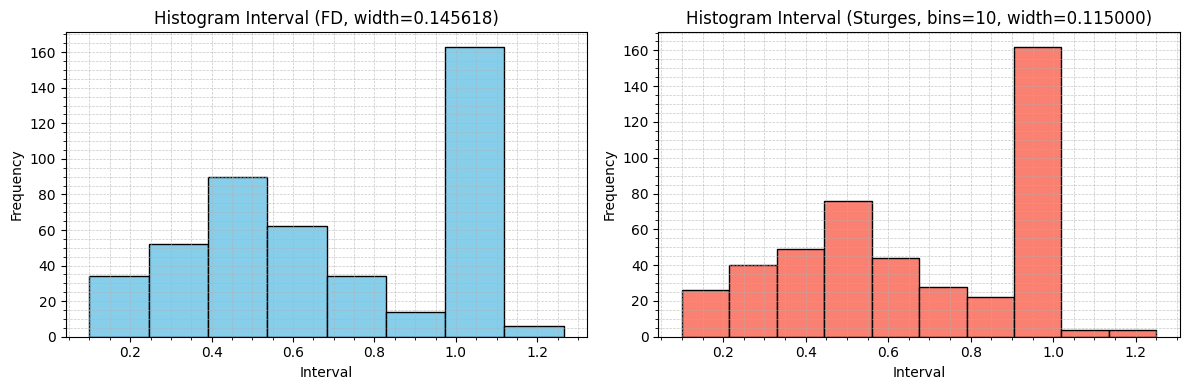


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.100000,0.245618,34
1,0.245618,0.391235,52
2,0.391235,0.536853,90
3,0.536853,0.682471,62
4,0.682471,0.828089,34
5,0.828089,0.973706,14
6,0.973706,1.119324,163
7,1.119324,1.264942,6



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.100,0.215,26
1,0.215,0.330,40
2,0.330,0.445,49
3,0.445,0.560,76
4,0.560,0.675,44
5,0.675,0.790,28
6,0.790,0.905,22
7,0.905,1.020,162
8,1.020,1.135,4
9,1.135,1.250,4


In [30]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return int(np.sqrt(n)), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series):
    data = series.dropna().values
    n = len(data)
    mean = np.mean(data)
    std = np.std(data, ddof=1)
    se = stats.sem(data)
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0] if n > 0 else None
    var = np.var(data, ddof=1)
    kurt = stats.kurtosis(data)
    skew = stats.skew(data)
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else None

    print("Descriptive statistics for Interval:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}")
    print(f"Sample Variance: {var:.6f}")
    print(f"Kurtosis: {kurt:.6f}")
    print(f"Skewness: {skew:.6f}")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): \u00b1{conf95:.6f}")

def plot_interval_histograms(df_filtered):
    if 'Interval' not in df_filtered.columns:
        print("Kolom 'Interval' tidak ada di dataframe.")
        return

    data = df_filtered['Interval'].dropna()

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data)

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins: {bins_fd}, bin width: {width_fd_str}")
    print(f"Sturges -> bins: {bins_st}, bin width: {width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram Interval (FD, width={width_fd_str})")
    axes[0].set_xlabel("Interval")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram Interval (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("Interval")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
interval_data = plot_interval_histograms(df_filtered) # Corrected function call

In [31]:
# Pastikan df_filtered sudah ada
# Contoh: df_filtered = filter_data(df_block, "LIM", "RLIM")

# Minta input dari user
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))

# Filter data sesuai input
df_interval = df_filtered[(df_filtered['Interval'] >= lower_bound) &
                       (df_filtered['Interval'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_interval)}")
display(df_interval.head(50))

Masukkan batas bawah (is greater than or equal to): 0.100000
Masukkan batas atas (is less than or equal to): 0.828089

Filtered rows: 272


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
306,CS8230860,Belambus Blok 1 Spasi 100,Belambus_Tengah,10.00,10.65,0.65,1.00,4.310,42.575,2.475,ESAP,LIM,LIM,LIM,2.260564,1.298120
308,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,5.00,5.40,0.40,1.00,1.810,51.381,0.880,ESAP,LIM,LIM,LIM,1.542665,0.750025
310,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.00,4.62,0.62,1.00,4.230,35.225,2.740,ESAP,LIM,LIM,LIM,2.325957,1.506648
312,CS8230746,Belambus Blok 1 Spasi 100,Belambus_Tengah,6.85,7.00,0.15,1.00,1.015,18.719,0.825,ESAP,LIM,LIM,LIM,2.306894,1.875062
316,CS8170156R,BATU BERANI,Belambus_Tengah,3.70,4.30,0.60,1.00,2.398,40.492,1.427,ESAP,None,LIM,LIM,1.367016,0.813483
318,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.62,5.00,0.38,1.00,1.900,40.789,1.125,ESAP,LIM,LIM,LIM,1.704602,1.009304
319,CS7211446,Belambus Spasi 50,Belambus_Tengah,5.00,5.44,0.44,1.47,3.815,38.794,2.335,Esap,None,LIM,LIM,2.017438,1.234788
320,CS7211447RR,Belambus Spasi 50,Belambus_Tengah,3.80,4.00,0.20,1.00,1.220,34.426,0.800,Esap,None,LIM,LIM,2.086438,1.368156
321,CS7211446,Belambus Spasi 50,Belambus_Tengah,4.20,5.00,0.80,1.18,5.000,35.900,3.205,Esap,None,LIM,LIM,1.811647,1.161266
322,CS7211442,Belambus Spasi 50,Belambus_Tengah,6.00,6.20,0.20,1.40,1.350,38.519,0.830,Esap,None,LIM,LIM,1.649117,1.013901


# Filter By Recovery


Descriptive statistics for CoreRec:
Count: 272
Mean: 1.092243
Standard Error: 0.011108
Median: 1.0
Mode: 1.0
Standard Deviation: 0.183204
Sample Variance: 0.033564
Kurtosis: 1.764114
Skewness: 1.356532
Range: 1.1400000000000001
Minimum: 0.69
Maximum: 1.83
Sum: 297.09000000000003
Confidence Level (95%): ±0.021870

Bin calculation:
Freedman–Diaconis -> bins=24, width=0.049389
Sturges -> bins=10, width=0.114000


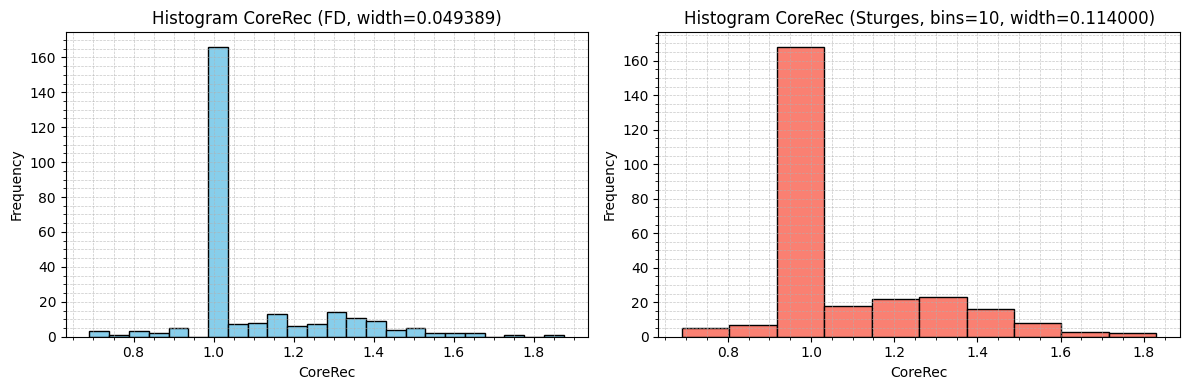


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.690000,0.739389,3
1,0.739389,0.788777,1
2,0.788777,0.838166,3
3,0.838166,0.887555,2
4,0.887555,0.936943,5
5,0.936943,0.986332,0
6,0.986332,1.035720,166
7,1.035720,1.085109,7
8,1.085109,1.134498,8
9,1.134498,1.183886,13



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.690,0.804,5
1,0.804,0.918,7
2,0.918,1.032,168
3,1.032,1.146,18
4,1.146,1.260,22
5,1.260,1.374,23
6,1.374,1.488,16
7,1.488,1.602,8
8,1.602,1.716,3
9,1.716,1.830,2


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import AutoMinorLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="CoreRec"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_coreRec(df_interval):
    if 'CoreRec' not in df_interval.columns:
        print("Kolom 'CoreRec' tidak ada di dataframe.")
        return

    data = df_interval['CoreRec'].dropna()
    if data.empty:
        print("Tidak ada data 'CoreRec' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="CoreRec")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram CoreRec (FD, width={width_fd_str})")
    axes[0].set_xlabel("CoreRec")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(AutoMinorLocator())
    axes[0].yaxis.set_minor_locator(AutoMinorLocator())
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram CoreRec (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("CoreRec")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(AutoMinorLocator())
    axes[1].yaxis.set_minor_locator(AutoMinorLocator())
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
coreRec_data = analyze_coreRec(df_interval)

In [33]:
lower_bound = float(input("Masukkan batas bawah (is greater than or equal to): "))
upper_bound = float(input("Masukkan batas atas (is less than or equal to): "))


df_recovery = df_interval[(df_interval['CoreRec'] >= lower_bound) &
                       (df_interval['CoreRec'] <= upper_bound)]

print(f"\nFiltered rows: {len(df_recovery)}")
display(df_recovery.head(47))

Masukkan batas bawah (is greater than or equal to): 0.918
Masukkan batas atas (is less than or equal to): 1.032

Filtered rows: 168


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF
306,CS8230860,Belambus Blok 1 Spasi 100,Belambus_Tengah,10.00,10.65,0.65,1.0,4.310,42.575,2.475,ESAP,LIM,LIM,LIM,2.260564,1.298120
308,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,5.00,5.40,0.40,1.0,1.810,51.381,0.880,ESAP,LIM,LIM,LIM,1.542665,0.750025
310,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.00,4.62,0.62,1.0,4.230,35.225,2.740,ESAP,LIM,LIM,LIM,2.325957,1.506648
312,CS8230746,Belambus Blok 1 Spasi 100,Belambus_Tengah,6.85,7.00,0.15,1.0,1.015,18.719,0.825,ESAP,LIM,LIM,LIM,2.306894,1.875062
316,CS8170156R,BATU BERANI,Belambus_Tengah,3.70,4.30,0.60,1.0,2.398,40.492,1.427,ESAP,None,LIM,LIM,1.367016,0.813483
318,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.62,5.00,0.38,1.0,1.900,40.789,1.125,ESAP,LIM,LIM,LIM,1.704602,1.009304
320,CS7211447RR,Belambus Spasi 50,Belambus_Tengah,3.80,4.00,0.20,1.0,1.220,34.426,0.800,Esap,None,LIM,LIM,2.086438,1.368156
323,CS7211372,Belambus Spasi 50,Belambus_Tengah,2.75,3.00,0.25,1.0,1.060,35.849,0.680,Esap,None,LIM,LIM,1.450246,0.930346
330,CS7211416R,Belambus Spasi 50,Belambus_Tengah,3.25,3.65,0.40,1.0,1.950,43.590,1.100,Esap,None,LIM,LIM,1.667440,0.940607
332,CS7211443,Belambus Spasi 50,Belambus_Tengah,5.23,6.00,0.77,1.0,3.270,48.471,1.685,Esap,None,LIM,LIM,1.452555,0.748488


# Filter By Wet Weight

Tidak ada data dengan Interval=1.0 dan CoreRec=1.0.
Menggunakan seluruh data sebagai acuan residual.

Residual IQR acuan:
Q1: -0.324, Q3: 0.268, IQR: 0.592
Lower margin: -1.211, Upper margin: 1.156


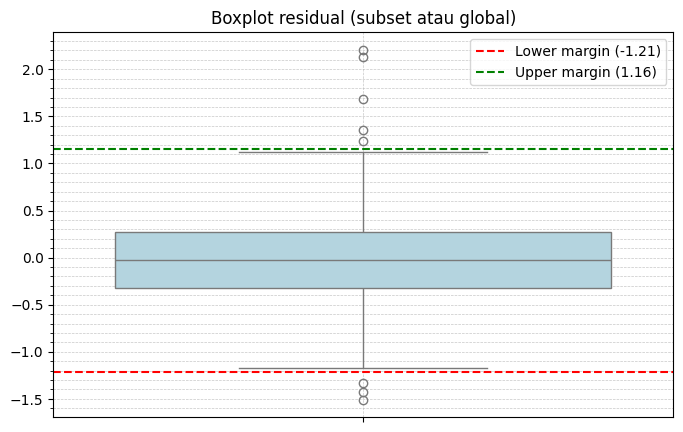

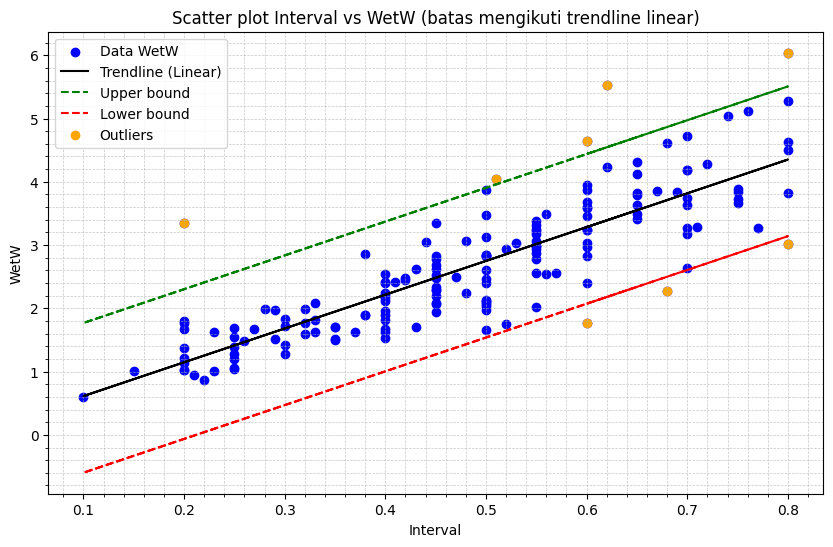


Outlier WetW berdasarkan trendline linear + IQR residual acuan:
        HoleId                       Hill       Hill_Group  From    To  \
418  CS7211449          Belambus Spasi 50  Belambus_Tengah   0.5  1.30   
440  CS7211443          Belambus Spasi 50  Belambus_Tengah   2.8  3.00   
516  CS7211443          Belambus Spasi 50  Belambus_Tengah   2.0  2.80   
559  CS8230772  Belambus Blok 1 Spasi 100  Belambus_Tengah   3.0  3.62   
647  CS8230753  Belambus Blok 1 Spasi 100  Belambus_Tengah   5.0  5.51   

     Interval  CoreRec   WetW     H2O   DryW Material Layer NEW_LYR GEN_LYR  \
418      0.80      1.0  6.040  26.159  4.460     Rlim  None     LIM     LIM   
440      0.20      1.0  3.355  25.633  2.495     Rlim  None     LIM     LIM   
516      0.80      1.0  3.015  23.051  2.320     Rlim  None     LIM     LIM   
559      0.62      1.0  5.525  29.140  3.915     YLIM   LIM     LIM     LIM   
647      0.51      1.0  4.045  40.173  2.420     YLIM   LIM     LIM     LIM   

          WTF  

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['WetW'], color='blue', label='Data WetW')
    plt.plot(df_recovery['Interval'], y_pred, color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], y_pred + upper_margin, color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], y_pred + lower_margin, color='red', linestyle='--', label='Lower bound')

    # Outlier = data di luar batas trendline ± margin
    outliers = df_recovery[(df_recovery['WetW'] > y_pred + upper_margin) |
                           (df_recovery['WetW'] < y_pred + lower_margin)]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("WetW")
    plt.legend()
    plt.show()

    return {
        "outliers": outliers,
        "margins": {"lower": lower_margin, "upper": upper_margin},
        "trendline_coef": {"slope": model.coef_[0], "intercept": model.intercept_}
    }

# --- Contoh pemanggilan ---
result = detect_outliers_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
if result:
    print("\nOutlier WetW berdasarkan trendline linear + IQR residual acuan:")
    print(result["outliers"].head())

## Normalisasi Weight terhadap recovery

In [35]:
import numpy as np
from IPython.display import display

def normalize_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns or 'CoreRec' not in df_recovery.columns:
        print("Kolom 'WetW' atau 'CoreRec' tidak ada di dataframe.")
        return df_recovery

    # Buat kolom baru Normalized_WetW
    df_recovery['Normalized_WetW'] = np.where(
        df_recovery['CoreRec'] > 1.0,
        df_recovery['WetW'] / 1,          # jika CoreRec > 1.0
        df_recovery['WetW'] / df_recovery['CoreRec']  # jika CoreRec <= 1.0
    )

    print("\nNormalisasi WetW terhadap Recovery selesai.")
    # tampilkan seluruh dataframe dengan kolom tambahan
    display(df_recovery)

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = normalize_wetw(df_recovery)


Normalisasi WetW terhadap Recovery selesai.


/tmp/ipython-input-7809237.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Normalized_WetW'] = np.where(


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW
306,CS8230860,Belambus Blok 1 Spasi 100,Belambus_Tengah,10.00,10.65,0.65,1.0,4.310,42.575,2.475,ESAP,LIM,LIM,LIM,2.260564,1.298120,4.310
308,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,5.00,5.40,0.40,1.0,1.810,51.381,0.880,ESAP,LIM,LIM,LIM,1.542665,0.750025,1.810
310,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.00,4.62,0.62,1.0,4.230,35.225,2.740,ESAP,LIM,LIM,LIM,2.325957,1.506648,4.230
312,CS8230746,Belambus Blok 1 Spasi 100,Belambus_Tengah,6.85,7.00,0.15,1.0,1.015,18.719,0.825,ESAP,LIM,LIM,LIM,2.306894,1.875062,1.015
316,CS8170156R,BATU BERANI,Belambus_Tengah,3.70,4.30,0.60,1.0,2.398,40.492,1.427,ESAP,None,LIM,LIM,1.367016,0.813483,2.398
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
753,CS7211420,Belambus Spasi 50,Belambus_Tengah,2.40,3.00,0.60,1.0,3.580,29.330,2.530,Ylim,None,LIM,LIM,2.040833,1.442265,3.580
756,CS7211395,Belambus Spasi 50,Belambus_Tengah,2.30,3.00,0.70,1.0,4.180,31.100,2.880,Ylim,None,LIM,LIM,2.042462,1.407246,4.180
757,CS7211448,Belambus Spasi 50,Belambus_Tengah,3.00,3.70,0.70,1.0,3.740,36.631,2.370,Ylim,None,LIM,LIM,1.827466,1.158046,3.740
762,CS7211415,Belambus Spasi 50,Belambus_Tengah,2.00,2.40,0.40,1.0,2.240,30.134,1.565,Ylimx,None,LIM,LIM,1.915419,1.338228,2.240


Tidak ada data dengan Interval=1.0 dan CoreRec=1.0.
Menggunakan seluruh data sebagai acuan residual.

Residual IQR acuan:
Q1: -0.317, Q3: 0.262, IQR: 0.579
Lower margin: -1.185, Upper margin: 1.130


/tmp/ipython-input-1577443899.py:50: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
/tmp/ipython-input-1577443899.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_recovery['Outlier_Status'] = [


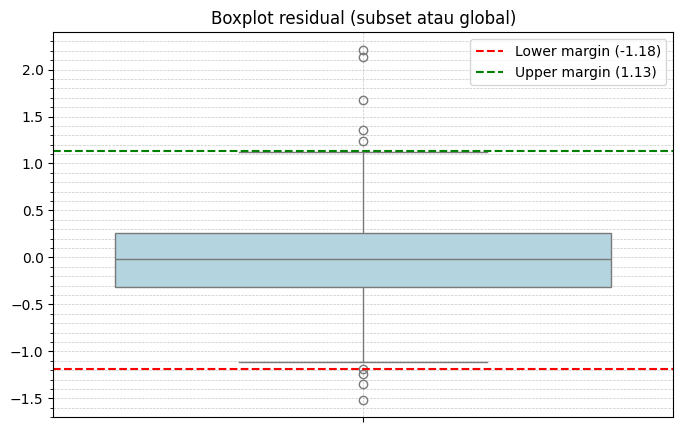

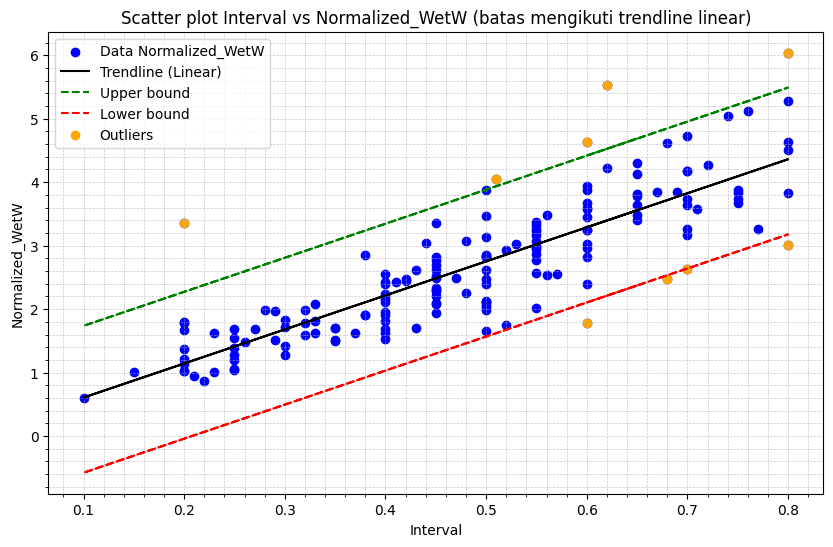

,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred,Outlier_Status
306,CS8230860,Belambus Blok 1 Spasi 100,Belambus_Tengah,10.00,10.65,0.65,1.0,4.310,42.575,2.475,ESAP,LIM,LIM,LIM,2.260564,1.298120,4.310,3.557034,Normal
308,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,5.00,5.40,0.40,1.0,1.810,51.381,0.880,ESAP,LIM,LIM,LIM,1.542665,0.750025,1.810,2.216027,Normal
310,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.00,4.62,0.62,1.0,4.230,35.225,2.740,ESAP,LIM,LIM,LIM,2.325957,1.506648,4.230,3.396114,Normal
312,CS8230746,Belambus Blok 1 Spasi 100,Belambus_Tengah,6.85,7.00,0.15,1.0,1.015,18.719,0.825,ESAP,LIM,LIM,LIM,2.306894,1.875062,1.015,0.875020,Normal
316,CS8170156R,BATU BERANI,Belambus_Tengah,3.70,4.30,0.60,1.0,2.398,40.492,1.427,ESAP,None,LIM,LIM,1.367016,0.813483,2.398,3.288833,Normal
318,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.62,5.00,0.38,1.0,1.900,40.789,1.125,ESAP,LIM,LIM,LIM,1.704602,1.009304,1.900,2.108746,Normal
320,CS7211447RR,Belambus Spasi 50,Belambus_Tengah,3.80,4.00,0.20,1.0,1.220,34.426,0.800,Esap,None,LIM,LIM,2.086438,1.368156,1.220,1.143221,Normal
323,CS7211372,Belambus Spasi 50,Belambus_Tengah,2.75,3.00,0.25,1.0,1.060,35.849,0.680,Esap,None,LIM,LIM,1.450246,0.930346,1.060,1.411423,Normal
330,CS7211416R,Belambus Spasi 50,Belambus_Tengah,3.25,3.65,0.40,1.0,1.950,43.590,1.100,Esap,None,LIM,LIM,1.667440,0.940607,1.950,2.216027,Normal
332,CS7211443,Belambus Spasi 50,Belambus_Tengah,5.23,6.00,0.77,1.0,3.270,48.471,1.685,Esap,None,LIM,LIM,1.452555,0.748488,3.270,4.200718,Normal


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import AutoMinorLocator
from sklearn.linear_model import LinearRegression

def detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00):
    # --- Filter subset sesuai kriteria ---
    subset = df_recovery[(df_recovery['Interval'] == interval_value) &
                         (df_recovery['CoreRec'] == coreRec_value)]

    # --- Fit trendline linear (Interval vs Normalized_WetW) ---
    X = df_recovery['Interval'].values.reshape(-1,1)
    y = df_recovery['Normalized_WetW'].values
    model = LinearRegression().fit(X, y)
    y_pred = model.predict(X)

    # --- Tentukan subset untuk residual ---
    if subset.empty:
        print(f"Tidak ada data dengan Interval={interval_value} dan CoreRec={coreRec_value}.")
        print("Menggunakan seluruh data sebagai acuan residual.")
        subset_X = X
        subset_y = y
    else:
        subset_X = subset['Interval'].values.reshape(-1,1)
        subset_y = subset['Normalized_WetW'].values

    subset_pred = model.predict(subset_X)
    residuals = subset_y - subset_pred

    # --- Hitung IQR residual subset/global ---
    q1, q3 = np.percentile(residuals, [25, 75])
    iqr = q3 - q1
    lower_margin = q1 - 1.5 * iqr
    upper_margin = q3 + 1.5 * iqr

    print(f"\nResidual IQR acuan:")
    print(f"Q1: {q1:.3f}, Q3: {q3:.3f}, IQR: {iqr:.3f}")
    print(f"Lower margin: {lower_margin:.3f}, Upper margin: {upper_margin:.3f}")

    # --- Tambahkan kolom status outlier ---
    def classify_outlier(val, pred):
        if val < pred + lower_margin:
            return "Outlier bawah"
        elif val > pred + upper_margin:
            return "Outlier atas"
        else:
            return "Normal"

    df_recovery['Trendline_Pred'] = model.predict(df_recovery['Interval'].values.reshape(-1,1))
    df_recovery['Outlier_Status'] = [
        classify_outlier(val, pred)
        for val, pred in zip(df_recovery['Normalized_WetW'], df_recovery['Trendline_Pred'])
    ]

    # --- Boxplot residual subset/global ---
    plt.figure(figsize=(8,5))
    sns.boxplot(y=residuals, color='lightblue')
    plt.axhline(lower_margin, color='red', linestyle='--', label=f'Lower margin ({lower_margin:.2f})')
    plt.axhline(upper_margin, color='green', linestyle='--', label=f'Upper margin ({upper_margin:.2f})')
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Boxplot residual (subset atau global)")
    plt.legend()
    plt.show()

    # --- Scatter plot seluruh data + trendline + batas mengikuti trendline ---
    plt.figure(figsize=(10,6))
    plt.scatter(df_recovery['Interval'], df_recovery['Normalized_WetW'], color='blue', label='Data Normalized_WetW')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'], color='black', label='Trendline (Linear)')

    # Batas atas/bawah mengikuti trendline
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + upper_margin,
             color='green', linestyle='--', label='Upper bound')
    plt.plot(df_recovery['Interval'], df_recovery['Trendline_Pred'] + lower_margin,
             color='red', linestyle='--', label='Lower bound')

    # Outlier ditandai oranye
    outliers = df_recovery[df_recovery['Outlier_Status'] != "Normal"]
    if not outliers.empty:
        plt.scatter(outliers['Interval'], outliers['Normalized_WetW'], color='orange', label='Outliers')

    plt.gca().xaxis.set_minor_locator(AutoMinorLocator())
    plt.gca().yaxis.set_minor_locator(AutoMinorLocator())
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.title("Scatter plot Interval vs Normalized_WetW (batas mengikuti trendline linear)")
    plt.xlabel("Interval")
    plt.ylabel("Normalized_WetW")
    plt.legend()
    plt.show()

    return df_recovery

# --- Contoh pemanggilan ---
df_recovery = detect_outliers_normalized_wetw_trend(df_recovery, interval_value=1.00, coreRec_value=1.00)
display(df_recovery.head(15))


Bin calculation:
Freedman–Diaconis -> bins=10, width=0.560907
Sturges -> bins=9, width=0.605000


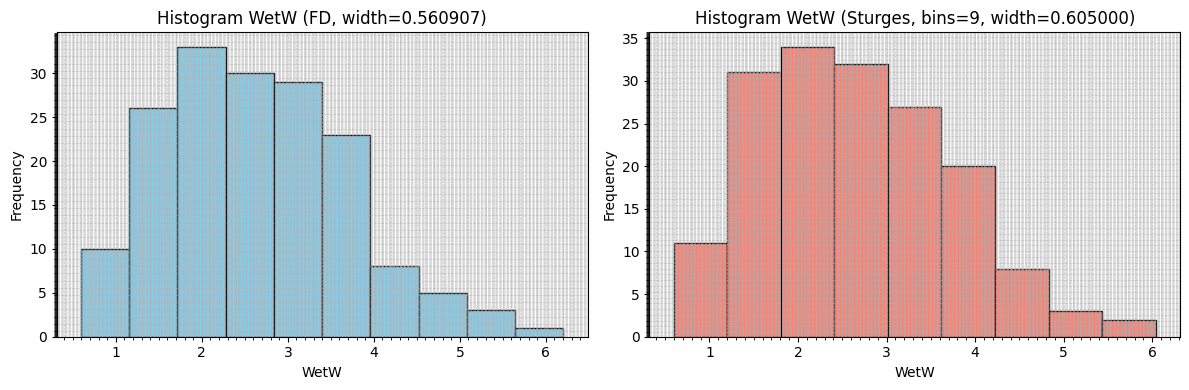


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.595000,1.155907,10
1,1.155907,1.716814,26
2,1.716814,2.277721,33
3,2.277721,2.838628,30
4,2.838628,3.399535,29
5,3.399535,3.960442,23
6,3.960442,4.521349,8
7,4.521349,5.082256,5
8,5.082256,5.643163,3
9,5.643163,6.204070,1



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.595,1.200,11
1,1.200,1.805,31
2,1.805,2.410,34
3,2.410,3.015,32
4,3.015,3.620,27
5,3.620,4.225,20
6,4.225,4.830,8
7,4.830,5.435,3
8,5.435,6.040,2


In [37]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def analyze_wetw(df_recovery):
    if 'WetW' not in df_recovery.columns:
        print("Kolom 'WetW' tidak ada di dataframe.")
        return

    data = df_recovery['WetW'].dropna()
    if data.empty:
        print("Tidak ada data 'WetW' yang valid setelah drop NaN.")
        return

    # --- hitung jumlah bins ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram WetW (FD, width={width_fd_str})")
    axes[0].set_xlabel("WetW")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram WetW (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("WetW")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
wetw_data = analyze_wetw(df_recovery)

In [39]:
import numpy as np
from IPython.display import display

def filter_wetw_normal(df_recovery, lower_bound, upper_bound):
    """
    Filter data WetW berdasarkan batas bawah/atas,
    sekaligus memastikan hanya baris dengan Outlier_Status = 'Normal' yang lolos.
    Setelah selesai, kolom Outlier_Status dihapus.
    """
    # --- Filter berdasarkan WetW ---
    df_wetw = df_recovery[(df_recovery['WetW'] >= lower_bound) &
                          (df_recovery['WetW'] <= upper_bound)].copy()

    # --- Pastikan hanya baris Normal yang lolos ---
    if 'Outlier_Status' in df_wetw.columns:
        df_wetw = df_wetw[df_wetw['Outlier_Status'] == "Normal"].copy()
        # Drop kolom Outlier_Status setelah selesai
        df_wetw = df_wetw.drop(columns=['Outlier_Status'])
    else:
        print("Kolom Outlier_Status tidak ditemukan, hanya filter WetW yang diterapkan.")

    print(f"\nFiltered rows (Normal only): {len(df_wetw)}")
    display(df_wetw.head(10))

    return df_wetw

# --- Contoh pemanggilan ---
lower_bound = float(input("Masukkan batas bawah (>=): "))
upper_bound = float(input("Masukkan batas atas (<=): "))

df_wetw = filter_wetw_normal(df_recovery, lower_bound, upper_bound)

Masukkan batas bawah (>=): 1.155907
Masukkan batas atas (<=): 3.960442

Filtered rows (Normal only): 136


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
308,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,5.00,5.40,0.40,1.0,1.810,51.381,0.880,ESAP,LIM,LIM,LIM,1.542665,0.750025,1.810,2.216027
316,CS8170156R,BATU BERANI,Belambus_Tengah,3.70,4.30,0.60,1.0,2.398,40.492,1.427,ESAP,None,LIM,LIM,1.367016,0.813483,2.398,3.288833
318,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.62,5.00,0.38,1.0,1.900,40.789,1.125,ESAP,LIM,LIM,LIM,1.704602,1.009304,1.900,2.108746
320,CS7211447RR,Belambus Spasi 50,Belambus_Tengah,3.80,4.00,0.20,1.0,1.220,34.426,0.800,Esap,None,LIM,LIM,2.086438,1.368156,1.220,1.143221
330,CS7211416R,Belambus Spasi 50,Belambus_Tengah,3.25,3.65,0.40,1.0,1.950,43.590,1.100,Esap,None,LIM,LIM,1.667440,0.940607,1.950,2.216027
332,CS7211443,Belambus Spasi 50,Belambus_Tengah,5.23,6.00,0.77,1.0,3.270,48.471,1.685,Esap,None,LIM,LIM,1.452555,0.748488,3.270,4.200718
334,CS7211372,Belambus Spasi 50,Belambus_Tengah,2.33,2.75,0.42,1.0,2.450,35.102,1.590,Esap,None,LIM,LIM,1.995228,1.294862,2.450,2.323308
336,CS7211416R,Belambus Spasi 50,Belambus_Tengah,3.65,4.00,0.35,1.0,1.700,44.412,0.945,Esap,None,LIM,LIM,1.661332,0.923505,1.700,1.947826
347,CS8230749,Belambus Blok 1 Spasi 100,Belambus_Tengah,1.00,1.55,0.55,1.0,2.990,14.883,2.545,GRV,GRV,LIM,LIM,1.853367,1.577531,2.990,3.020631
349,CS8230740,Belambus Blok 1 Spasi 100,Belambus_Tengah,0.00,0.40,0.40,1.0,2.160,19.907,1.730,GRV,LIM,LIM,LIM,1.840970,1.474481,2.160,2.216027


#Filter By MC


Descriptive statistics for H2O:
Count: 136
Mean: 29.397949
Standard Error: 0.900972
Median: 29.082
Mode: 5.049
Standard Deviation: 10.507051
Sample Variance: 110.398122
Kurtosis: -0.538212
Skewness: 0.035376
Range: 46.737
Minimum: 5.049
Maximum: 51.786
Sum: 3998.1209999999996
Confidence Level (95%): ±1.781846

Bin calculation:
Freedman–Diaconis -> bins=9, width=5.548400
Sturges -> bins=9, width=5.193000


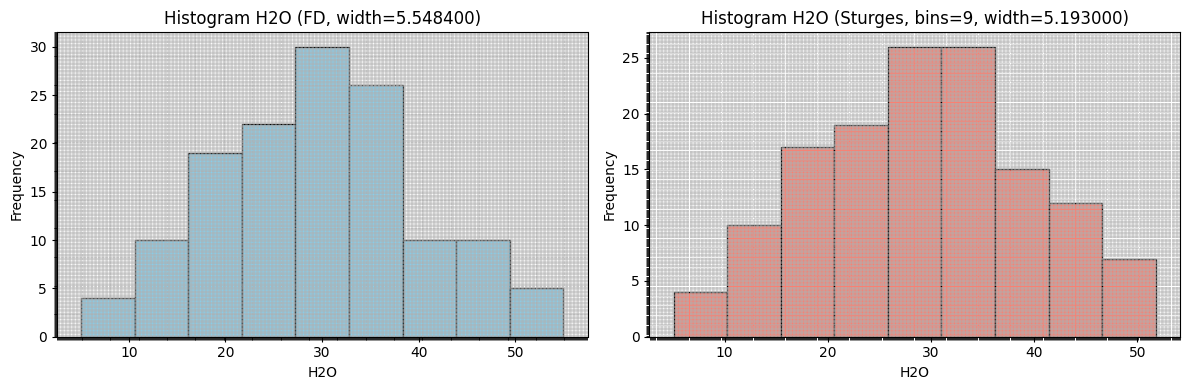


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,5.049000,10.597400,4
1,10.597400,16.145801,10
2,16.145801,21.694201,19
3,21.694201,27.242602,22
4,27.242602,32.791002,30
5,32.791002,38.339403,26
6,38.339403,43.887803,10
7,43.887803,49.436204,10
8,49.436204,54.984604,5



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,5.049,10.242,4
1,10.242,15.435,10
2,15.435,20.628,17
3,20.628,25.821,19
4,25.821,31.014,26
5,31.014,36.207,26
6,36.207,41.400,15
7,41.400,46.593,12
8,46.593,51.786,7


In [40]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="H2O"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_h2o(df_wetw):
    if 'H2O' not in df_wetw.columns:
        print("Kolom 'H2O' tidak ada di dataframe.")
        return

    data = df_wetw['H2O'].dropna()
    if data.empty:
        print("Tidak ada data 'H2O' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="H2O")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram H2O (FD, width={width_fd_str})")
    axes[0].set_xlabel("H2O")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram H2O (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("H2O")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
h2o_data = analyze_h2o(df_wetw)

In [41]:

import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_wetw berdasarkan H2O
df_h2o = df_wetw[(df_wetw['H2O'] >= lower_bound) &
                 (df_wetw['H2O'] <= upper_bound)].copy()

print(f"\nFiltered rows (H2O): {len(df_h2o)}")
display(df_h2o.head(10))

is greater than or equal to: 15.435
is less than or equal to: 41.400

Filtered rows (H2O): 103


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
316,CS8170156R,BATU BERANI,Belambus_Tengah,3.70,4.30,0.60,1.0,2.398,40.492,1.427,ESAP,None,LIM,LIM,1.367016,0.813483,2.398,3.288833
318,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.62,5.00,0.38,1.0,1.900,40.789,1.125,ESAP,LIM,LIM,LIM,1.704602,1.009304,1.900,2.108746
320,CS7211447RR,Belambus Spasi 50,Belambus_Tengah,3.80,4.00,0.20,1.0,1.220,34.426,0.800,Esap,None,LIM,LIM,2.086438,1.368156,1.220,1.143221
334,CS7211372,Belambus Spasi 50,Belambus_Tengah,2.33,2.75,0.42,1.0,2.450,35.102,1.590,Esap,None,LIM,LIM,1.995228,1.294862,2.450,2.323308
349,CS8230740,Belambus Blok 1 Spasi 100,Belambus_Tengah,0.00,0.40,0.40,1.0,2.160,19.907,1.730,GRV,LIM,LIM,LIM,1.840970,1.474481,2.160,2.216027
355,CS8230749,Belambus Blok 1 Spasi 100,Belambus_Tengah,1.55,2.00,0.45,1.0,2.520,21.825,1.970,RLIM,LIM,LIM,LIM,1.909154,1.492474,2.520,2.484228
363,CS8230753,Belambus Blok 1 Spasi 100,Belambus_Tengah,1.00,1.45,0.45,1.0,2.295,19.826,1.840,RLIM,LIM,LIM,LIM,1.738694,1.393985,2.295,2.484228
372,CS4170015,BATU BERANI,Belambus_Tengah,1.00,1.25,0.25,1.0,1.692,23.345,1.297,RLIM,None,LIM,LIM,2.314920,1.774499,1.692,1.411423
383,CS8170162,BATU BERANI,Belambus_Tengah,3.00,3.40,0.40,1.0,2.213,30.230,1.544,RLIM,None,LIM,LIM,1.892331,1.320271,2.213,2.216027
386,CS8170156R,BATU BERANI,Belambus_Tengah,2.00,2.30,0.30,1.0,1.834,17.830,1.507,RLIM,None,LIM,LIM,2.090999,1.718176,1.834,1.679624


# Filter By DTF


Descriptive statistics for DTF:
Count: 103
Mean: 1.331835
Standard Error: 0.025776
Median: 1.318225367
Mode: 1.473398947
Standard Deviation: 0.261597
Sample Variance: 0.068433
Kurtosis: 0.217053
Skewness: 0.395826
Range: 1.3513613910000002
Minimum: 0.813482853
Maximum: 2.164844244
Sum: 137.17899124000002
Confidence Level (95%): ±0.051126

Bin calculation:
Freedman–Diaconis -> bins=9, width=0.161594
Sturges -> bins=8, width=0.168920


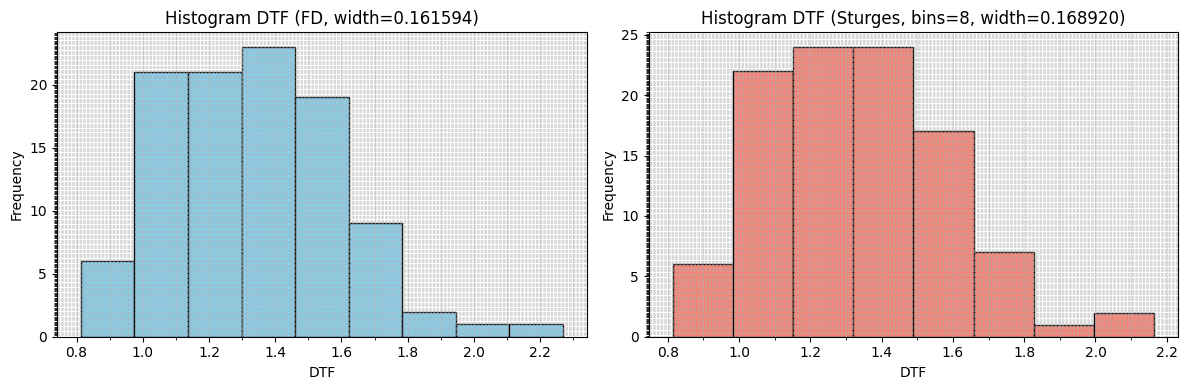


Tabel Histogram (Freedman–Diaconis):


,Bin Start,Bin End,Frequency
0,0.813483,0.975077,6
1,0.975077,1.136672,21
2,1.136672,1.298266,21
3,1.298266,1.459861,23
4,1.459861,1.621455,19
5,1.621455,1.783050,9
6,1.783050,1.944644,2
7,1.944644,2.106239,1
8,2.106239,2.267833,1



Tabel Histogram (Sturges):


,Bin Start,Bin End,Frequency
0,0.813483,0.982403,6
1,0.982403,1.151323,22
2,1.151323,1.320243,24
3,1.320243,1.489164,24
4,1.489164,1.658084,17
5,1.658084,1.827004,7
6,1.827004,1.995924,1
7,1.995924,2.164844,2


In [42]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import pandas as pd
from matplotlib.ticker import MultipleLocator

def compute_bins(series, method='fd'):
    data = series.dropna().values
    n = len(data)
    if n < 2:
        return 10, None
    if method == 'fd':
        q75, q25 = np.percentile(data, [75, 25])
        iqr = q75 - q25
        if iqr == 0:
            return max(5, int(np.sqrt(n))), None
        h = 2 * iqr / (n ** (1/3))   # Freedman–Diaconis bin width
        bins = max(5, int(np.ceil((data.max() - data.min()) / h)))
        return bins, h
    elif method == 'sturges':
        if n == 0 or (data.max() - data.min()) == 0:
            return max(5, int(np.sqrt(n))), None
        bins = int(np.ceil(np.log2(n) + 1))
        h = (data.max() - data.min()) / bins
        return bins, h
    else:
        return 10, None

def descriptive_stats(series, label="DTF"):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

def analyze_dtf(df_h2o):
    if 'DTF' not in df_h2o.columns:
        print("Kolom 'DTF' tidak ada di dataframe.")
        return

    data = df_h2o['DTF'].dropna()
    if data.empty:
        print("Tidak ada data 'DTF' yang valid setelah drop NaN.")
        return

    # --- tampilkan descriptive statistics ---
    descriptive_stats(data, label="DTF")

    # --- hitung jumlah bins dan bin width ---
    bins_fd, h_fd = compute_bins(data, method='fd')
    bins_st, h_st = compute_bins(data, method='sturges')

    width_fd_str = f"{h_fd:.6f}" if h_fd is not None else "N/A"
    width_st_str = f"{h_st:.6f}" if h_st is not None else "N/A"

    print("\nBin calculation:")
    print(f"Freedman–Diaconis -> bins={bins_fd}, width={width_fd_str}")
    print(f"Sturges -> bins={bins_st}, width={width_st_str}")

    # --- plot histogram dengan minor ticks interval 0.1 ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Freedman–Diaconis pakai edges manual agar width konsisten
    if h_fd is not None and h_fd > 0:
        edges_fd = np.arange(data.min(), data.max() + h_fd, h_fd)
    else:
        edges_fd = np.linspace(data.min(), data.max(), bins_fd+1)

    counts_fd, edges_fd, _ = axes[0].hist(data, bins=edges_fd, color='skyblue', edgecolor='black')
    axes[0].set_title(f"Histogram DTF (FD, width={width_fd_str})")
    axes[0].set_xlabel("DTF")
    axes[0].set_ylabel("Frequency")
    axes[0].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[0].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    # Sturges pakai jumlah bin
    counts_st, edges_st, _ = axes[1].hist(data, bins=bins_st, color='salmon', edgecolor='black')
    axes[1].set_title(f"Histogram DTF (Sturges, bins={bins_st}, width={width_st_str})")
    axes[1].set_xlabel("DTF")
    axes[1].set_ylabel("Frequency")
    axes[1].xaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].yaxis.set_minor_locator(MultipleLocator(0.1))
    axes[1].grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)

    plt.tight_layout()
    plt.show()

    # --- buat tabel histogram ---
    table_fd = pd.DataFrame({
        "Bin Start": edges_fd[:-1],
        "Bin End": edges_fd[1:],
        "Frequency": counts_fd.astype(int)
    })

    table_st = pd.DataFrame({
        "Bin Start": edges_st[:-1],
        "Bin End": edges_st[1:],
        "Frequency": counts_st.astype(int)
    })

    print("\nTabel Histogram (Freedman–Diaconis):")
    display(table_fd)

    print("\nTabel Histogram (Sturges):")
    display(table_st)

    return data

# --- Contoh pemanggilan ---
dtf_data = analyze_dtf(df_h2o)

In [43]:
import numpy as np
from IPython.display import display

# Input batas bawah dan atas untuk H2O
lower_bound = float(input("is greater than or equal to: "))
upper_bound = float(input("is less than or equal to: "))

# Filter df_h2o berdasarkan DTF
df_dtf = df_h2o[(df_h2o['DTF'] >= lower_bound) &
                (df_h2o['DTF'] <= upper_bound)].copy()

print(f"\nFiltered rows (DTF): {len(df_dtf)}")
display(df_dtf.head(89))

is greater than or equal to: 0.975077
is less than or equal to: 1.621455

Filtered rows (DTF): 84


,HoleId,Hill,Hill_Group,From,To,Interval,CoreRec,WetW,H2O,DryW,Material,Layer,NEW_LYR,GEN_LYR,WTF,DTF,Normalized_WetW,Trendline_Pred
318,CS8230772,Belambus Blok 1 Spasi 100,Belambus_Tengah,4.62,5.00,0.38,1.0,1.90,40.789,1.125,ESAP,LIM,LIM,LIM,1.704602,1.009304,1.90,2.108746
320,CS7211447RR,Belambus Spasi 50,Belambus_Tengah,3.80,4.00,0.20,1.0,1.22,34.426,0.800,Esap,None,LIM,LIM,2.086438,1.368156,1.22,1.143221
334,CS7211372,Belambus Spasi 50,Belambus_Tengah,2.33,2.75,0.42,1.0,2.45,35.102,1.590,Esap,None,LIM,LIM,1.995228,1.294862,2.45,2.323308
349,CS8230740,Belambus Blok 1 Spasi 100,Belambus_Tengah,0.00,0.40,0.40,1.0,2.16,19.907,1.730,GRV,LIM,LIM,LIM,1.840970,1.474481,2.16,2.216027
355,CS8230749,Belambus Blok 1 Spasi 100,Belambus_Tengah,1.55,2.00,0.45,1.0,2.52,21.825,1.970,RLIM,LIM,LIM,LIM,1.909154,1.492474,2.52,2.484228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
746,CS7211446,Belambus Spasi 50,Belambus_Tengah,2.33,3.00,0.67,1.0,3.85,28.052,2.770,Ylim,None,LIM,LIM,1.965448,1.414102,3.85,3.664315
753,CS7211420,Belambus Spasi 50,Belambus_Tengah,2.40,3.00,0.60,1.0,3.58,29.330,2.530,Ylim,None,LIM,LIM,2.040833,1.442265,3.58,3.288833
757,CS7211448,Belambus Spasi 50,Belambus_Tengah,3.00,3.70,0.70,1.0,3.74,36.631,2.370,Ylim,None,LIM,LIM,1.827466,1.158046,3.74,3.825236
762,CS7211415,Belambus Spasi 50,Belambus_Tengah,2.00,2.40,0.40,1.0,2.24,30.134,1.565,Ylimx,None,LIM,LIM,1.915419,1.338228,2.24,2.216027


# SUMMARY

In [44]:
import numpy as np
import scipy.stats as stats

def descriptive_stats(series, label):
    data = series.dropna().values
    n = len(data)
    if n == 0:
        print(f"\nNo data available for {label}.")
        return

    mean = np.mean(data)
    std = np.std(data, ddof=1) if n > 1 else np.nan
    se = stats.sem(data) if n > 1 else np.nan
    median = np.median(data)
    mode = stats.mode(data, keepdims=True).mode[0]
    var = np.var(data, ddof=1) if n > 1 else np.nan
    kurt = stats.kurtosis(data) if n > 3 else np.nan
    skew = stats.skew(data) if n > 2 else np.nan
    rng = np.max(data) - np.min(data)
    conf95 = stats.t.ppf(0.975, n-1) * se if n > 1 else np.nan

    print(f"\nDescriptive statistics for {label}:")
    print(f"Count: {n}")
    print(f"Mean: {mean:.6f}")
    print(f"Standard Error: {se:.6f}" if not np.isnan(se) else "Standard Error: N/A")
    print(f"Median: {median}")
    print(f"Mode: {mode}")
    print(f"Standard Deviation: {std:.6f}" if not np.isnan(std) else "Standard Deviation: N/A")
    print(f"Sample Variance: {var:.6f}" if not np.isnan(var) else "Sample Variance: N/A")
    print(f"Kurtosis: {kurt:.6f}" if not np.isnan(kurt) else "Kurtosis: N/A")
    print(f"Skewness: {skew:.6f}" if not np.isnan(skew) else "Skewness: N/A")
    print(f"Range: {rng}")
    print(f"Minimum: {np.min(data)}")
    print(f"Maximum: {np.max(data)}")
    print(f"Sum: {np.sum(data)}")
    print(f"Confidence Level (95%): ±{conf95:.6f}" if not np.isnan(conf95) else "Confidence Level (95%): N/A")

# --- Jalankan untuk semua kolom yang diminta ---
target_columns = ["Interval", "CoreRec", "WetW", "H2O", "DryW", "WTF", "DTF"]

for col in target_columns:
    if col in df_dtf.columns:
        descriptive_stats(df_dtf[col], label=col)
    else:
        print(f"\nKolom {col} tidak ditemukan di df_dtf.")


Descriptive statistics for Interval:
Count: 84
Mean: 0.505476
Standard Error: 0.014707
Median: 0.5
Mode: 0.5
Standard Deviation: 0.134795
Sample Variance: 0.018170
Kurtosis: -0.554330
Skewness: -0.072181
Range: 0.6000000000000001
Minimum: 0.2
Maximum: 0.8
Sum: 42.46
Confidence Level (95%): ±0.029252

Descriptive statistics for CoreRec:
Count: 84
Mean: 0.999048
Standard Error: 0.000952
Median: 1.0
Mode: 1.0
Standard Deviation: 0.008729
Sample Variance: 0.000076
Kurtosis: 79.012048
Skewness: -9.000669
Range: 0.07999999999999996
Minimum: 0.92
Maximum: 1.0
Sum: 83.92
Confidence Level (95%): ±0.001894

Descriptive statistics for WetW:
Count: 84
Mean: 2.713202
Standard Error: 0.083428
Median: 2.8
Mode: 2.11
Standard Deviation: 0.764627
Sample Variance: 0.584654
Kurtosis: -1.000371
Skewness: -0.216249
Range: 2.689
Minimum: 1.195
Maximum: 3.884
Sum: 227.90900000000002
Confidence Level (95%): ±0.165934

Descriptive statistics for H2O:
Count: 84
Mean: 29.542536
Standard Error: 0.652598
Median: 

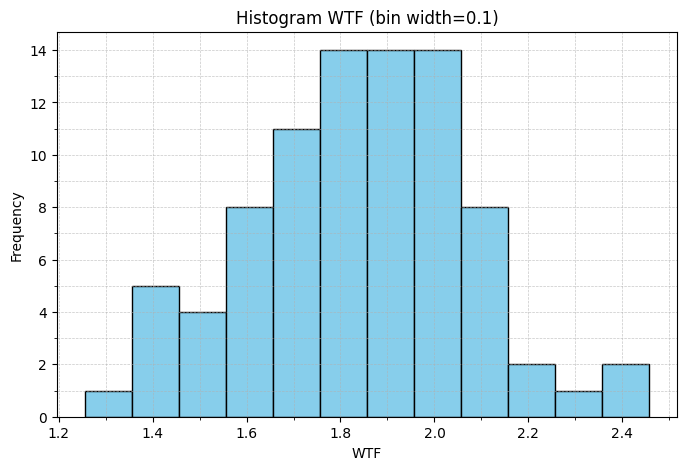


Tabel Histogram WTF:


,Bin Start,Bin End,Frequency
0,1.256216,1.356216,1
1,1.356216,1.456216,5
2,1.456216,1.556216,4
3,1.556216,1.656216,8
4,1.656216,1.756216,11
5,1.756216,1.856216,14
6,1.856216,1.956216,14
7,1.956216,2.056216,14
8,2.056216,2.156216,8
9,2.156216,2.256216,2


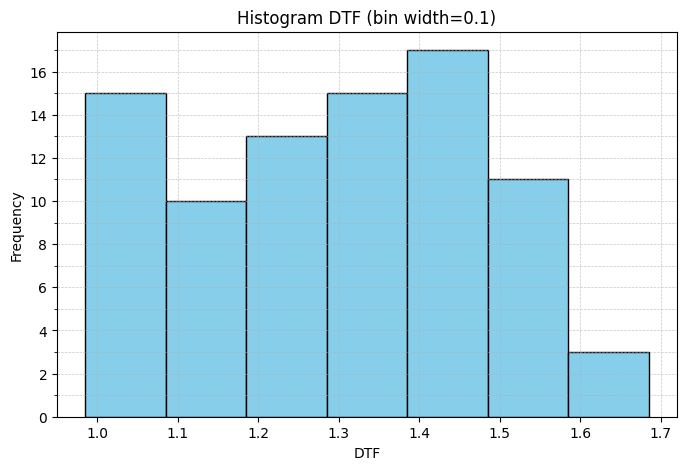


Tabel Histogram DTF:


,Bin Start,Bin End,Frequency
0,0.985072,1.085072,15
1,1.085072,1.185072,10
2,1.185072,1.285072,13
3,1.285072,1.385072,15
4,1.385072,1.485072,17
5,1.485072,1.585072,11
6,1.585072,1.685072,3


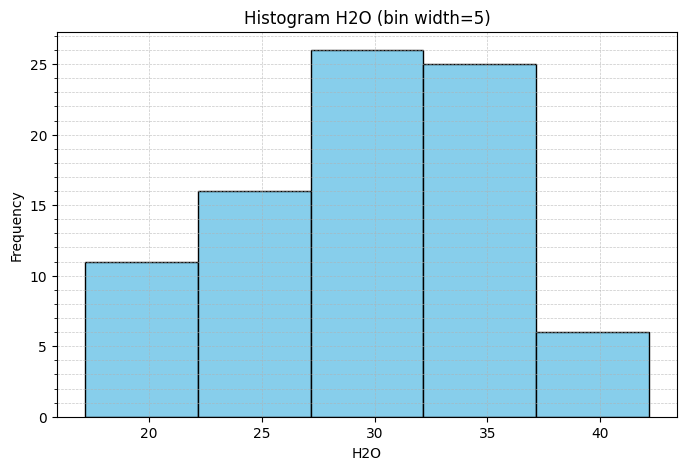


Tabel Histogram H2O:


,Bin Start,Bin End,Frequency
0,17.162,22.162,11
1,22.162,27.162,16
2,27.162,32.162,26
3,32.162,37.162,25
4,37.162,42.162,6


In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.ticker import MultipleLocator

def plot_histogram_fixed_width(series, bin_width, label):
    data = series.dropna().values
    if len(data) == 0:
        print(f"Tidak ada data untuk {label}.")
        return None

    # Tentukan bins berdasarkan bin_width
    min_val, max_val = data.min(), data.max()
    bins = np.arange(min_val, max_val + bin_width, bin_width)

    # Plot histogram
    plt.figure(figsize=(8,5))
    counts, edges, _ = plt.hist(data, bins=bins, color='skyblue', edgecolor='black')
    plt.title(f"Histogram {label} (bin width={bin_width})")
    plt.xlabel(label)
    plt.ylabel("Frequency")

    # Minor ticks sesuai bin width
    plt.gca().xaxis.set_minor_locator(MultipleLocator(bin_width))
    plt.gca().yaxis.set_minor_locator(MultipleLocator(1))
    plt.grid(which='both', linestyle='--', linewidth=0.5, alpha=0.7)
    plt.show()

    # Buat tabel histogram
    table = pd.DataFrame({
        "Bin Start": edges[:-1],
        "Bin End": edges[1:],
        "Frequency": counts.astype(int)
    })

    print(f"\nTabel Histogram {label}:")
    display(table)
    return table

# --- Contoh pemanggilan ---
table_wtf = plot_histogram_fixed_width(df_dtf['WTF'], bin_width=0.1, label="WTF")
table_dtf = plot_histogram_fixed_width(df_dtf['DTF'], bin_width=0.1, label="DTF")
table_h2o = plot_histogram_fixed_width(df_dtf['H2O'], bin_width=5, label="H2O")

In [46]:
import pandas as pd

# Input nama Block, GEN_LYR, dan Material
block_name = input("Masukkan nama Block: ")
gen_lyr = input("Masukkan GEN_LYR: ")

# Hitung nilai ringkasan (contoh: mean)
summary = {
    "Block": block_name,
    "GEN_LYR": gen_lyr,
    "Interval_mean": df_dtf['Interval'].dropna().mean(),
    "CoreRec_mean": df_dtf['CoreRec'].dropna().mean(),
    "WetW_mean": df_dtf['WetW'].dropna().mean(),
    "H2O_mean": df_dtf['H2O'].dropna().mean(),
    "DryW_mean": df_dtf['DryW'].dropna().mean(),
    "WTF_mean": df_dtf['WTF'].dropna().mean(),
    "DTF_mean": df_dtf['DTF'].dropna().mean()
}

# Buat nama variabel DataFrame sesuai input
var_name = f"df_{block_name.replace(' ', '_').lower()}_{gen_lyr.lower()}"
globals()[var_name] = pd.DataFrame([summary])

print(f"\nTabel Ringkasan tersimpan sebagai variabel: {var_name}")
display(globals()[var_name])

Masukkan nama Block: Belambus Tengah
Masukkan GEN_LYR: LIM

Tabel Ringkasan tersimpan sebagai variabel: df_belambus_tengah_lim


,Block,GEN_LYR,Interval_mean,CoreRec_mean,WetW_mean,H2O_mean,DryW_mean,WTF_mean,DTF_mean
0,Belambus Tengah,LIM,0.505476,0.999048,2.713202,29.542536,1.910131,1.840736,1.295034
